In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#pip list --format=freeze > requirement.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# defination the function to optimize the memory usage of the dataframe
def optimize_dataframe_for_memory(df):
 print("current memory usage: ", df.memory_usage().sum() / 1024**2, "MB")

 for col in df.columns:
  _max = df[col].max()
  _min = df[col].min()
  if df[col].dtype  == 'int64':
   if _min > np.iinfo(np.int8).min and _max < np.iinfo(np.int8).max:
    df[col] = df[col].astype(np.int8)
   elif _min > np.iinfo(np.int16).min and _max < np.iinfo(np.int16).max:
    df[col] = df[col].astype(np.int16)
   elif _min > np.iinfo(np.int32).min and _max < np.iinfo(np.int32).max:
    df[col] = df[col].astype(np.int32)
  elif df[col].dtype == 'float64':
   if _min > np.finfo(np.float16).min and _max < np.finfo(np.float16).max:
    df[col] = df[col].astype(np.float16)
   elif _min > np.finfo(np.float32).min and _max < np.finfo(np.float32).max:
    df[col] = df[col].astype(np.float32)
  else:
   continue
 
 print("new memory usage: ", df.memory_usage().sum() / 1024**2, "MB")
 return df

In [3]:
read_path = './data/'
save_path = './results/'
fig_save_path = "./figure/"
order_products_train = optimize_dataframe_for_memory(pd.read_csv(read_path+"order_products__train.csv"))
order_products_prior = optimize_dataframe_for_memory(pd.read_csv(read_path+"order_products__prior.csv"))
orders = optimize_dataframe_for_memory(pd.read_csv(read_path+"orders.csv"))
products = optimize_dataframe_for_memory(pd.read_csv(read_path+"products.csv"))
aisles = optimize_dataframe_for_memory(pd.read_csv(read_path+"aisles.csv"))
departments = optimize_dataframe_for_memory(pd.read_csv(read_path+"departments.csv"))

current memory usage:  42.25528335571289 MB
new memory usage:  13.204862594604492 MB
current memory usage:  989.8221778869629 MB
new memory usage:  340.25145626068115 MB
current memory usage:  182.70566940307617 MB
new memory usage:  68.51470470428467 MB
current memory usage:  1.5164833068847656 MB
new memory usage:  0.7109184265136719 MB
current memory usage:  0.002170562744140625 MB
new memory usage:  0.00140380859375 MB
current memory usage:  0.000446319580078125 MB
new memory usage:  0.00030612945556640625 MB


In [4]:
# combine order_products_train and order_products_prior
order_products = pd.concat( [ order_products_train , order_products_prior ])
order_products.shape

(33819106, 4)

In [5]:
order_products = order_products.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(33819106, 15)

In [6]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   product_id              int32  
 2   add_to_cart_order       int16  
 3   reordered               int8   
 4   product_name            object 
 5   aisle_id                int16  
 6   department_id           int8   
 7   aisle                   object 
 8   department              object 
 9   user_id                 int32  
 10  eval_set                object 
 11  order_number            int8   
 12  order_dow               int8   
 13  order_hour_of_day       int8   
 14  days_since_prior_order  float16
dtypes: float16(1), int16(2), int32(3), int8(5), object(4)
memory usage: 1.7+ GB


Departments Distribution

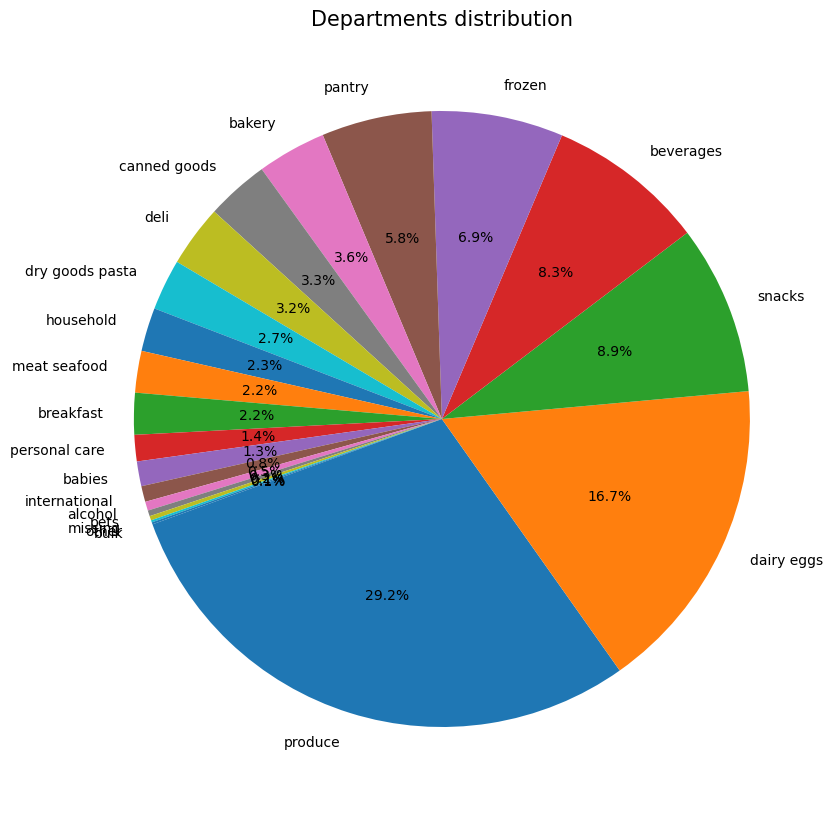

In [7]:
plt.figure(figsize=(10,10))
temp_series = order_products['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.savefig(fig_save_path+"Departments distribution.png")
plt.show()

User level analysis

Total Unique Product Users

    index            product_name  unique_users
0    3677                  Banana         76125
1    3472  Bag of Organic Bananas         65655
2   31923    Organic Strawberries         61129
3   28843    Organic Baby Spinach         56766
4   22415             Large Lemon         48614
5   23422                   Limes         46658
6   42908            Strawberries         44857
7   30300    Organic Hass Avocado         44704
8   28807         Organic Avocado         43954
9   29011     Organic Blueberries         38720
10  30003          Organic Garlic         36232
11  32568    Organic Yellow Onion         35550
12  32608        Organic Zucchini         33981
13  31366     Organic Raspberries         32915
14  49319           Yellow Onions         31112
15  11632          Cucumber Kirby         30706
16  30142  Organic Grape Tomatoes         30121
17  39708     Seedless Red Grapes         28702
18  30580           Organic Lemon         28205
19  29390        Organic Cilantro       

C:\Users\Lisa\AppData\Local\Temp\ipykernel_14168\1347375312.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_products['product_name'], x=top_20_products['unique_users'], palette='viridis')


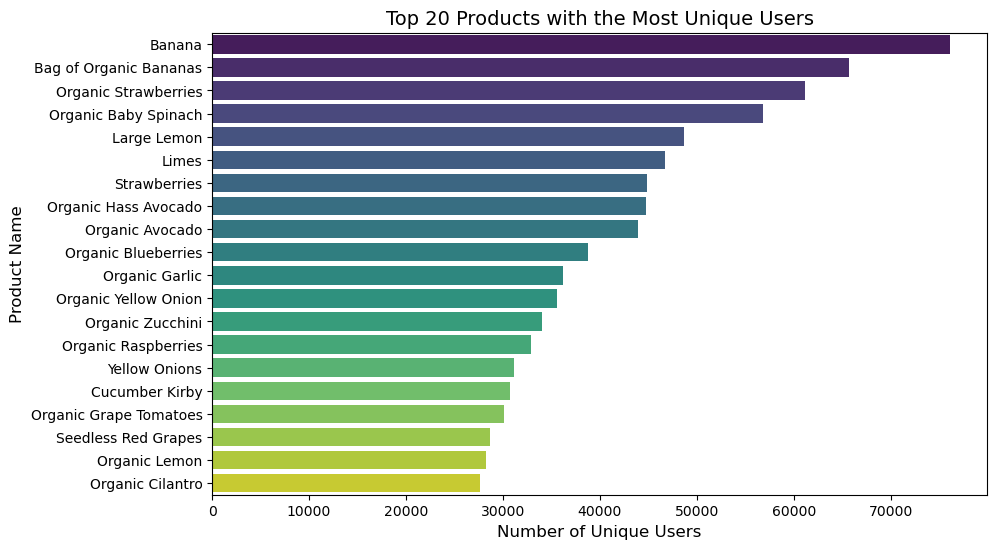

In [8]:
"""Which products have a high number of unique users?
The more unique users a product has, the more popular it is."""
# Group by product_name and count the number of unique users
unique_product_user = order_products.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id': 'unique_users'})
unique_product_user = unique_product_user.sort_values('unique_users', ascending=False).reset_index()
print(unique_product_user.head(20))
# Top 20 products by unique users
top_20_products = unique_product_user.head(20)
# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(y=top_20_products['product_name'], x=top_20_products['unique_users'], palette='viridis')
# Adding labels and title
plt.xlabel('Number of Unique Users', fontsize=12)
plt.ylabel('Product Name', fontsize=12)
plt.title('Top 20 Products with the Most Unique Users', fontsize=14)
plt.savefig(fig_save_path+"Top 20 Products with the Most Unique Users.png")
plt.show()

Product Sales VS  Unique Users

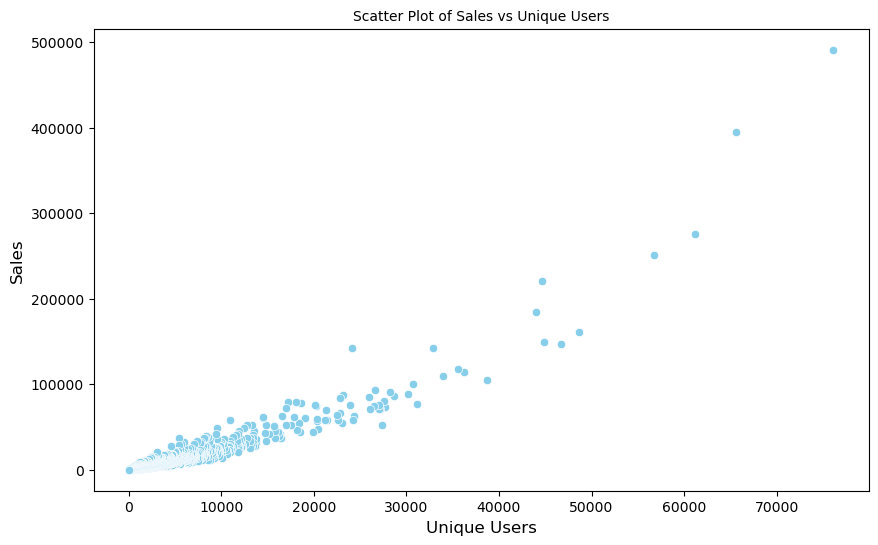

In [9]:
tol_product_sales = order_products.groupby('product_name').size().reset_index(name='sales') #compute the number of sales for each product
# Merge unique users and product sales
merged_data = pd.merge(unique_product_user, tol_product_sales, on='product_name')
# Plot scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='unique_users', y='sales', color='skyblue')
plt.xlabel('Unique Users', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.title('Scatter Plot of Sales vs Unique Users', fontsize=10)
plt.savefig(fig_save_path+"Scatter Plot of Sales vs Unique Users.png")
plt.show()

Unique Users VS Reorder Ratio

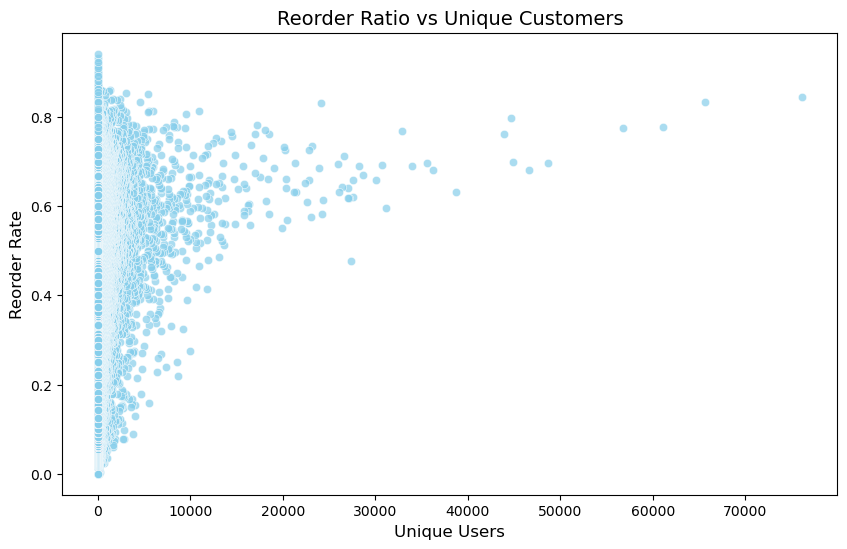

In [10]:
# Calculate reorder count and reorder rate
reorder_counts = order_products.groupby('product_id')['reordered'].sum().reset_index(name='reorder_count')
reorder_counts['reorder_rate'] = reorder_counts['reorder_count'] / order_products.groupby('product_id')['reordered'].count().values
reorder_counts_with_names = pd.merge(reorder_counts, products, on='product_id')
# Merge reorder data with the existing merged_data
merged_data = pd.merge(merged_data, reorder_counts_with_names[['product_name', 'reorder_count', 'reorder_rate']], on='product_name', how='left')
# Plotting the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='unique_users', y='reorder_rate', data=merged_data, color='skyblue', alpha=0.7)
plt.xlabel('Unique Users', fontsize=12)
plt.ylabel('Reorder Rate', fontsize=12)
plt.title('Reorder Ratio vs Unique Customers', fontsize=14)
plt.savefig(fig_save_path+"Reorder Ratio vs Unique Customers.png")
plt.show()


Product Sales VS  Reorder Ratio

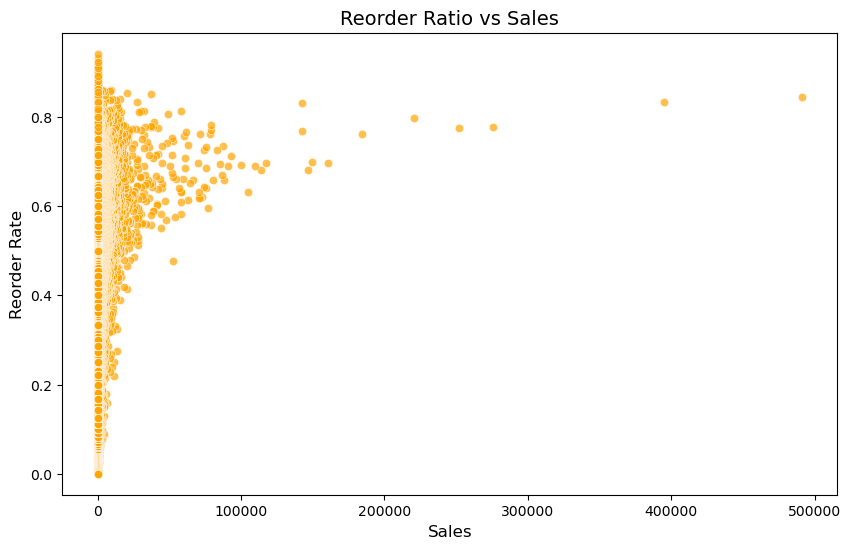

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sales', y='reorder_rate', data=merged_data, color='orange', alpha=0.7)
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Reorder Rate', fontsize=12)
plt.title('Reorder Ratio vs Sales', fontsize=14)
plt.savefig(fig_save_path+"Reorder Ratio vs Sales.png")
plt.show()

Add_to_cart_order VS Reordered

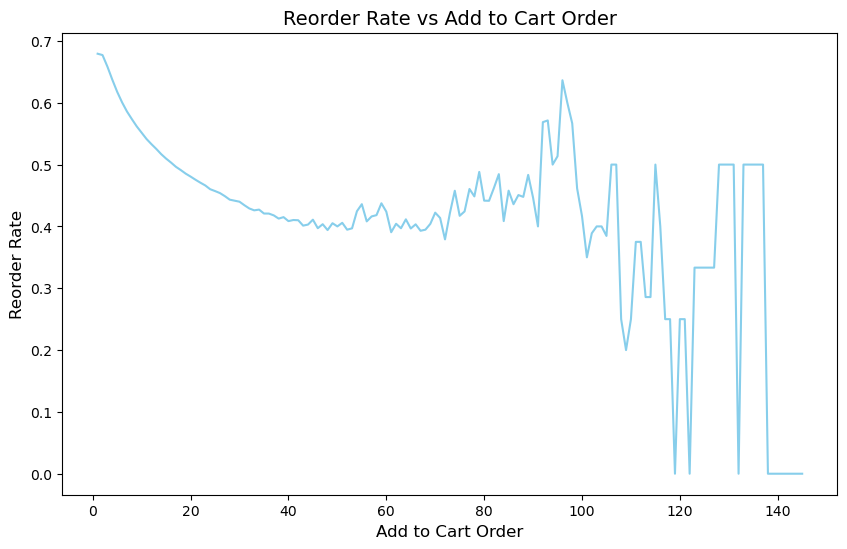

In [12]:
#compute the reorder rate(mean) for each add_to_cart_order
order_by_reorder = order_products.groupby('add_to_cart_order')['reordered'].mean().reset_index() 
# Plot the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='add_to_cart_order', y='reordered', data=order_by_reorder, color='skyblue')
plt.xlabel('Add to Cart Order', fontsize=12)
plt.ylabel('Reorder Rate', fontsize=12)
plt.title('Reorder Rate vs Add to Cart Order', fontsize=14)
plt.savefig(fig_save_path+"Reorder Rate vs Add to Cart Order.png")
plt.show()

Correlation Analysis (not good)

In [13]:
#build a matrix of aisles and orders
df = pd.DataFrame(columns=order_products['aisle'].unique()) 
df_list = []
newobj = {}
temp_order_id = 0
for row in order_products.head(100000).itertuples(index=True, name='Pandas'):
    if temp_order_id != row.order_id:
        if temp_order_id != 0:
            b = pd.DataFrame.from_dict([newobj]) 
            df_list.append(newobj)
        newobj = {}
        temp_order_id = row.order_id
        newobj["Index"] = row.order_id
    newobj[row.aisle] = 1
df_list.append(newobj)
df = pd.DataFrame(df_list).fillna(0) 

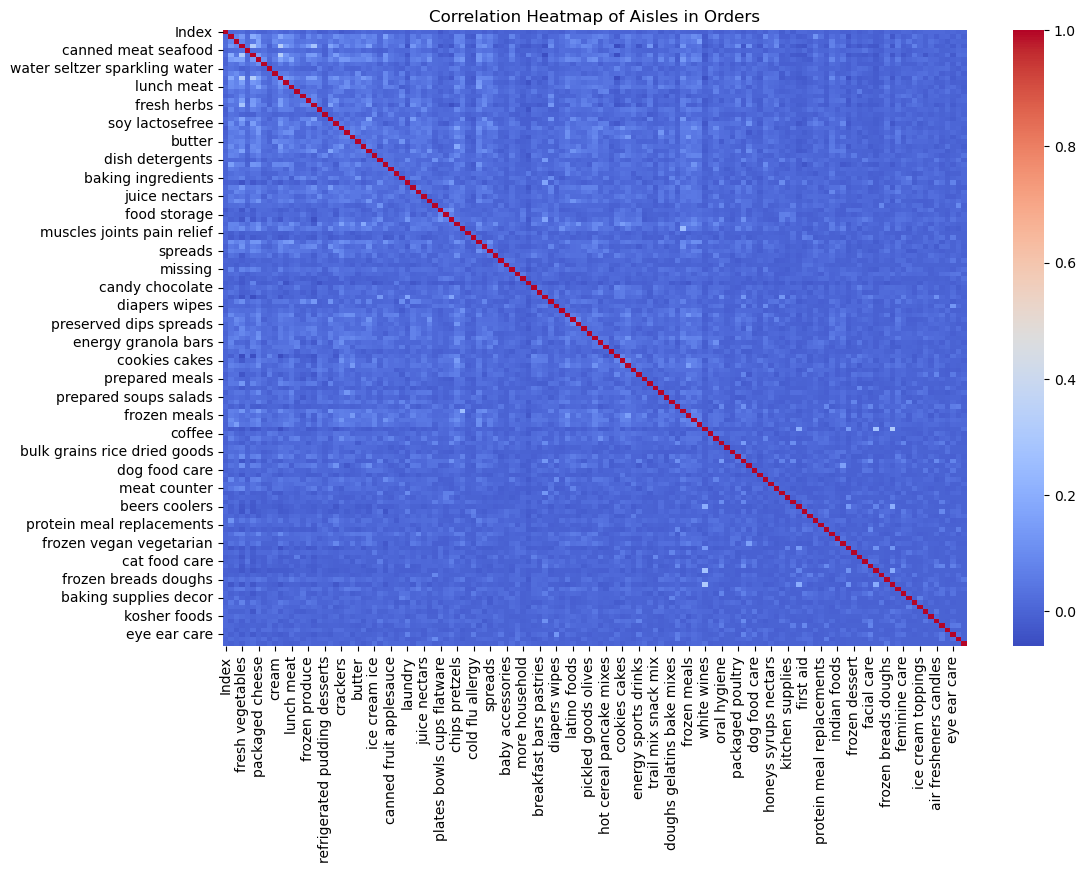

In [14]:
# Plot the correlation heatmap of aisles in orders
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Aisles in Orders")
plt.savefig(fig_save_path+"Correlation Heatmap of Aisles in Orders.png")
plt.show()